In [ ]:
#!pip install -r reuquirements.txt

# Set up environment

In [89]:
import numpy as np
import pandas as pd

from time import sleep
from pathlib import Path

from fastdownload import download_url
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import matplotlib.pyplot as plt
import random
from PIL import Image

import shutil
import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

import functions

import yaml
import os

import time

import create_yaml_files as yaml_files

import mlflow

# Create & import YAML files

In [62]:
yaml_files.create_yaml_files()

Dictionaries updated and saved.


# Source images

In [4]:
#Run this code when sourcing images from Kaggle account. However, do not run this when images are already sourced.
# class Images:
#     '''
#     A class to source images.
#     '''
#     def __init__(self, num_images):
#         self.num_images = num_images
#         self.orig_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'
#         self.dest_dir = '/kaggle/working/cifake'

#     def copy_images(self):
#         categories = ['FAKE', 'REAL']
#         dataset_type = ['train', 'test']

#         #Copy train & test images
#         for i in dataset_type:
#             for j in categories:
#                 orig_dir = os.path.join(self.orig_dir, i, j)
#                 dest_dir = os.path.join(self.dest_dir, i, j)
#                 functions.source_images(orig_dir = orig_dir, dest_dir = dest_dir, num_images = self.num_images, seed = 23)
#         #Copy validation images
#         for j in categories:
#             train_dir= os.path.join(self.dest_dir, 'train', j)
#             validation_dir = '/kaggle/working/cifake/validation'

#             all_files = os.listdir(train_dir)
#             random.seed(23)
#             selected_files = random.sample(all_files, 100)

#             for file in selected_files:
#                 train_file_path = os.path.join(train_dir, file)
#                 validation_file_path = os.path.join(validation_dir, j, file)
#                 os.makedirs(validation_file_path, exist_ok=True)
#                 shutil.copy(train_file_path, validation_file_path)

#                 os.remove(train_file_path)

# Preprocess images

In [15]:
class Preprocess:
    def __init__(self, **mdict):
        self.mdict = mdict

    def create_generators(self):
        train_datagen = ImageDataGenerator(
            rescale = self.mdict['generators']['rescale'],
            rotation_range = self.mdict['generators']['rotation_range'],
            width_shift_range = self.mdict['generators']['width_shift_range'],
            height_shift_range = self.mdict['generators']['height_shift_range'],
            shear_range = self.mdict['generators']['shear_range'],
            zoom_range = self.mdict['generators']['zoom_range'],
            fill_mode = self.mdict['generators']['fill_mode'])

        train_generator = train_datagen.flow_from_directory(
            self.mdict['info']['train_dir'],
            target_size = (224, 224),
            batch_size = 32,
            classes = self.mdict['info']['classes'])

        validation_generator = ImageDataGenerator().flow_from_directory(
            self.mdict['info']['validation_dir'],
            target_size = (224, 224),
            batch_size = 32,
            classes = self.mdict['info']['classes'])

        test_generator = ImageDataGenerator().flow_from_directory(
            self.mdict['info']['test_dir'],
            target_size = (224, 224),
            batch_size = 32,
            classes = self.mdict['info']['classes'],
            shuffle = False)

        return train_generator, validation_generator, test_generator

# Train and save CNN models

In [94]:
class CNN_model:
    def __init__(self, train_generator, validation_generator, **mdict):
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.mdict = mdict

    def define_architecture(self):
        model = Sequential()

        #Convolutional layers
        for i, conv in enumerate(self.mdict['conv_layers']):
            if i==0:
                model.add(Conv2D(
                    filters = conv['filters'],
                    kernel_size = conv['kernel_size'],
                    activation =conv['activation'],
                    input_shape= conv['input_shape']
                ))
            else:
                model.add(Conv2D(
                    filters = conv['filters'],
                    kernel_size = conv['kernel_size'],
                    activation =conv['activation']
                ))

            model.add(MaxPooling2D(self.mdict['maxpool_layers']['pool_size']))

        #Flatten
        model.add(Flatten())

        #Dropout
        model.add(Dropout(self.mdict['model']['dropout']))

        #Dense layers
        model.add(Dense(
            units = self.mdict['dense_layers']['units'],
            activation = self.mdict['dense_layers']['activation']))

        #Output
        model.add(Dense(
            units = self.mdict['output_layer']['units'],
            activation = self.mdict['output_layer']['activation']))

        return model

    def compile_model(self):
        model = self.define_architecture()
        model.compile(
            loss= self.mdict['model']['loss'],
            optimizer= self.mdict['model']['optimizer'],
            metrics=self.mdict['model']['metrics'])
        return model

    def fit_model (self):
        model = self.compile_model()

        log_dir = "../output/logs/" + self.mdict['info']['model_name']
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = model.fit(self.train_generator,
                            steps_per_epoch = self.mdict['model']['steps_per_epoch'],
                            epochs = self.mdict['model']['epochs'],
                            validation_data = self.validation_generator, 
                            #validation_steps = self.mdict['model']['validation_steps'],
                            callbacks=[tensorboard_callback]
                            )

        return history, model

    def save_model(self):
        history, model = self.fit_model()
        model.save(self.mdict['info']['model_filepath'])

        with open(self.mdict['info']['history_filepath'], 'wb') as file:
            pickle.dump(history.history, file)

        return history

# Import YAML files and train models

In [97]:
start_time = time.time()  # Start timing

yaml_files = [
    '../input/base_dict.yaml',
    #'../input/epoch_dict.yaml',
    #'../input/sgd_dict.yaml',
    #'../input/sigmoid_dict.yaml',
    #'../input/val_dict.yaml'
]

# Loop through each YAML file
for yaml_file in yaml_files:
    with open(yaml_file, 'r') as file:
        df_dict = yaml.safe_load(file)

    print(f"Training model with configuration from {yaml_file}: {df_dict}")

    # Create and train the model
    generator = Preprocess(**df_dict)
    train_generator, validation_generator, test_generator = generator.create_generators()
    model = CNN_model(train_generator, validation_generator, **df_dict)
    history = model.save_model()
    print(f"Finished training model with {df_dict}")

end_time = time.time()  # End timing
elapsed_time = end_time - start_time


Training model with configuration from ../input/base_dict.yaml: {'conv_layers': [{'activation': 'relu', 'filters': 32, 'input_shape': [224, 224, 3], 'kernel_size': [3, 3]}, {'activation': 'relu', 'filters': 32, 'input_shape': [224, 224, 3], 'kernel_size': [3, 3]}], 'dense_layers': {'activation': 'relu', 'units': 512}, 'generators': {'fill_mode': 'nearest', 'height_shift_range': 0.2, 'rescale': 0.00392156862745098, 'rotation_range': 40, 'shear_range': 0.2, 'width_shift_range': 0.2, 'zoom_range': 0.2}, 'info': {'classes': ['REAL', 'FAKE'], 'history_filepath': '../output/history_cifake_base.pkl', 'model_filepath': '../output/cifake_base.h5', 'model_name': 'base', 'test_dir': '../input/images/test', 'train_dir': '../input/images/train', 'validation_dir': '../input/images/validation'}, 'maxpool_layers': {'pool_size': [2, 2]}, 'model': {'dropout': 0.5, 'epochs': 20, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'adam', 'steps_per_epoch': 25, 'validation_steps': 23

KeyboardInterrupt: 

# Evaluate models

In [91]:
mlruns_path = '../output/mlruns'

if not os.path.exists(mlruns_path):
    os.makedirs(mlruns_path)

mlflow.set_tracking_uri(mlruns_path)

In [92]:
class Evaluate_model:
    def __init__(self, test_generator):
        self.test_generator = test_generator
        self.test_table = pd.DataFrame()
        self.histories = []
        self.history_names = []

    def add_history(self, history, name):
        self.histories.append(history)
        self.history_names.append(name)

    def visualize_training(self, metrics):
        functions.calc_histories(metrics, self.histories, self.history_names)

    def calc_metrics(self, model, name):
        row, accuracy, precision, recall, f1, y_true, y_pred_classes, y_pred = functions.calc_eval_metrics(model, name, self.test_generator)

        row_data = {
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

        self.test_table = pd.concat([self.test_table, pd.DataFrame([row_data])], ignore_index=True)

        #Log to mlflow
        metrics = {'accuracy': accuracy, 
                  'precision': precision,
                  'recall': recall,
                  'F1 Score:': f1
        }
        

        functions.log_mlflow(name, metrics)

        return accuracy, precision, recall, f1, y_true, y_pred_classes, y_pred

    def plot_confusion_matrix(self, model, name):
        accuracy, precision, recall, f1, y_true, y_pred_classes, y_pred = self.calc_metrics(model, name)
        functions.calc_confusion_matrix(y_true, y_pred_classes, name)

    def plot_roc_curve(self, model, name):
        accuracy, precision, recall, f1, y_true, y_pred_classes, y_pred = self.calc_metrics(model, name)
        n_classes = self.test_generator.num_classes
        y_test_bin = label_binarize(y_true, classes=[0, 1])

        functions.calc_roc_curve(n_classes, y_true, y_pred, name)

    def get_metrics_dataframe(self):
        return self.test_table

# Visualize accuracy and loss during training

In [93]:
metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
functions.plot_histories(metrics, all_histories, all_history_names)

NameError: name 'all_histories' is not defined

# Evaluate performance of models on test data set

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step


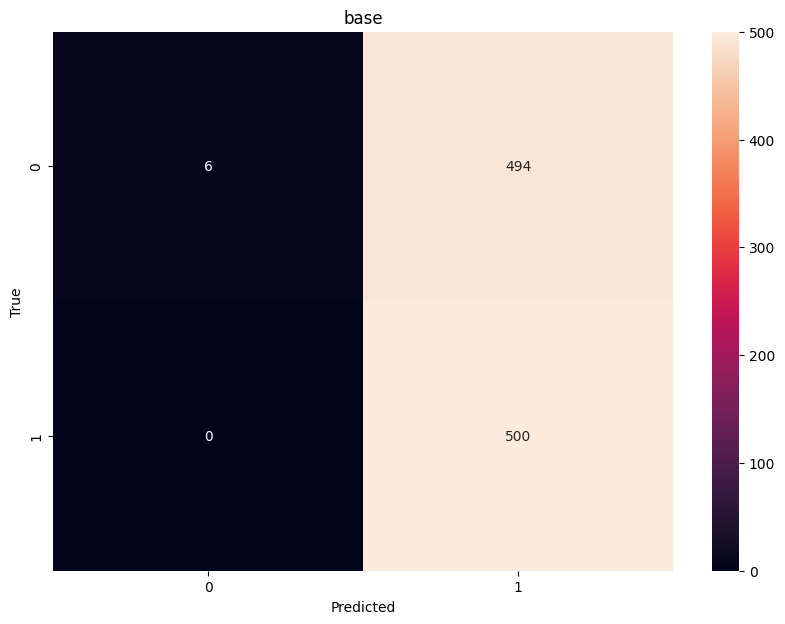

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step


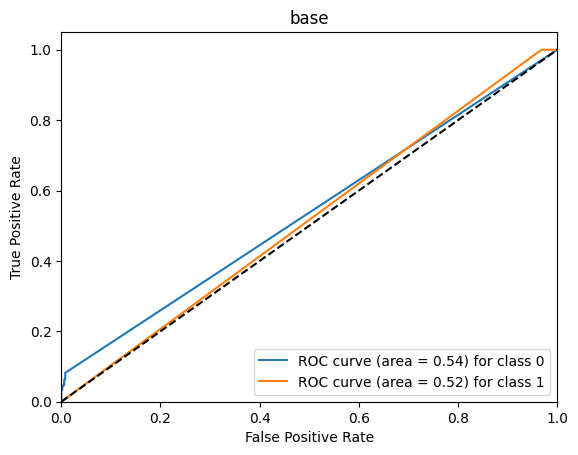

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step


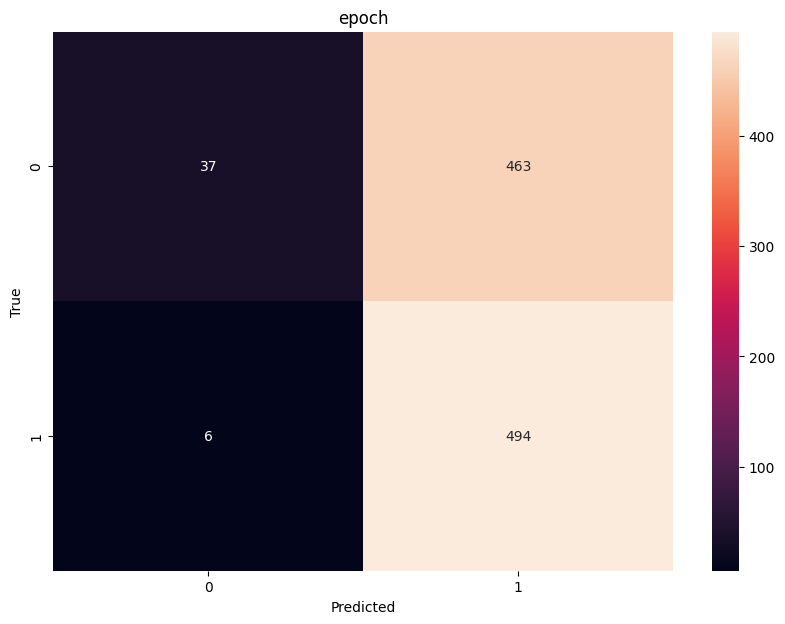

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step


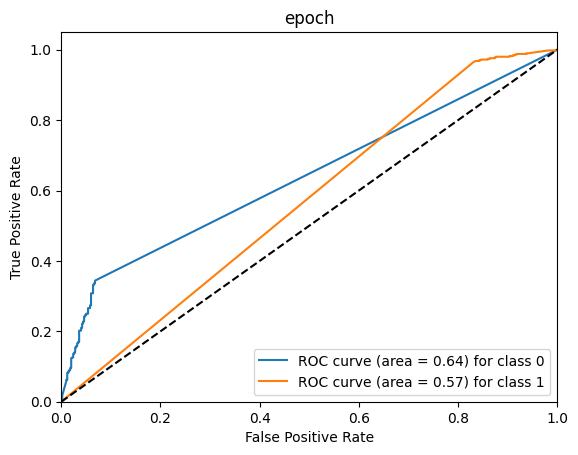

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step


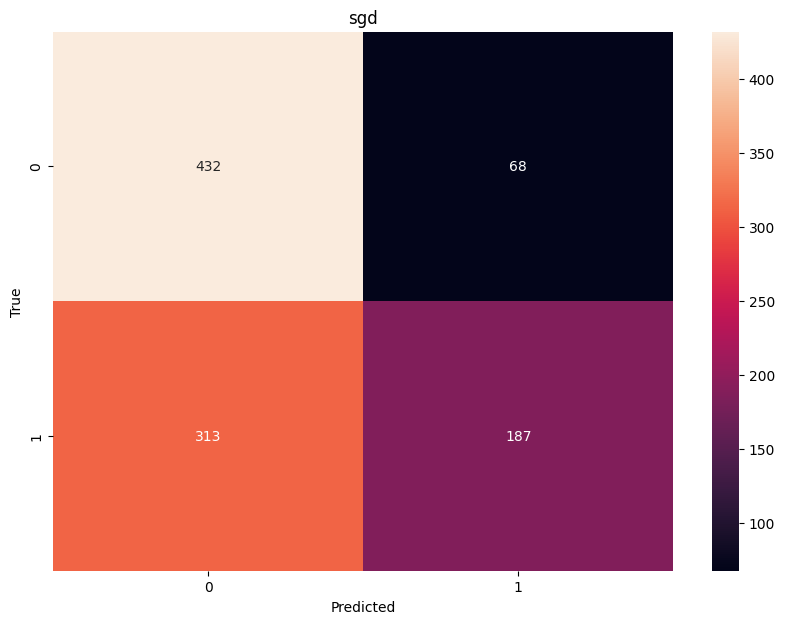

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step


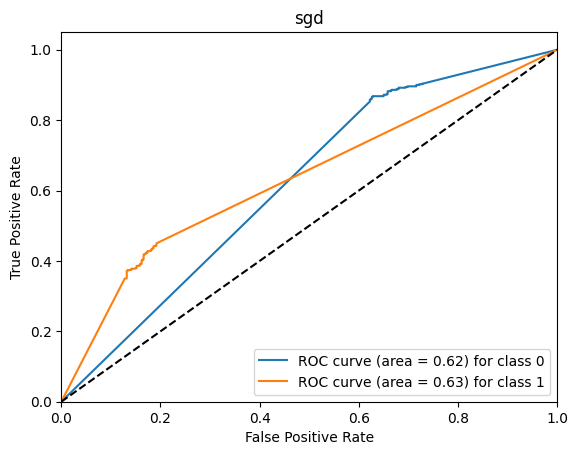

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step


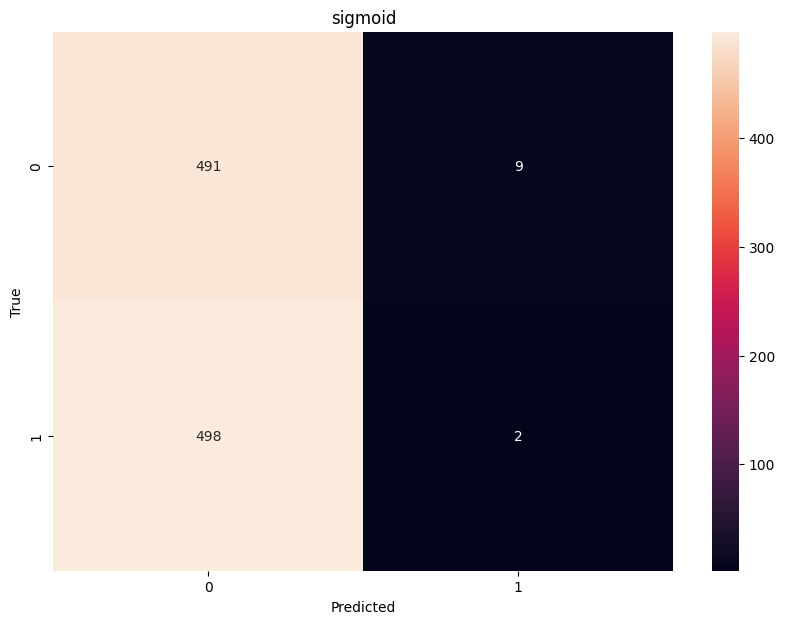

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step


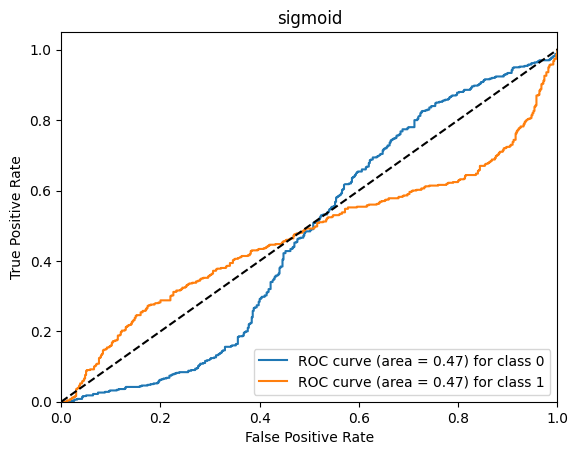

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step


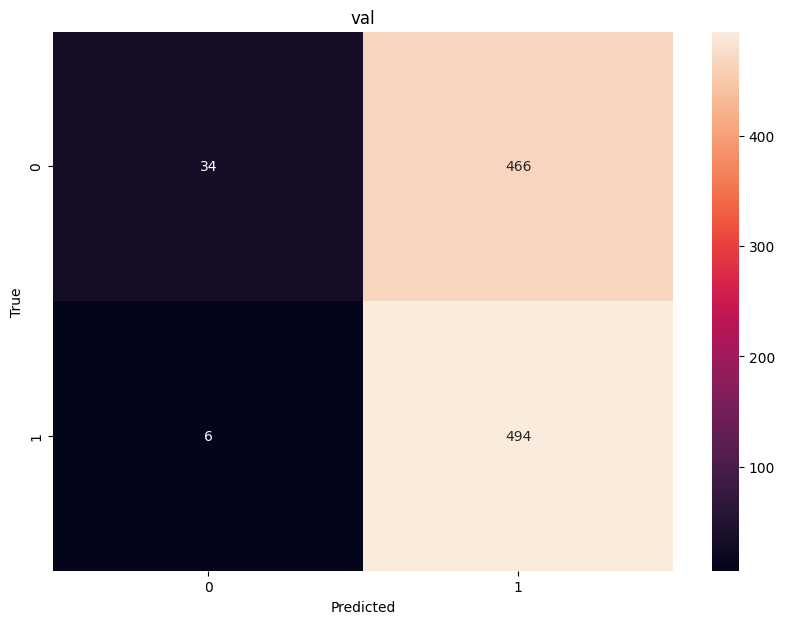

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step


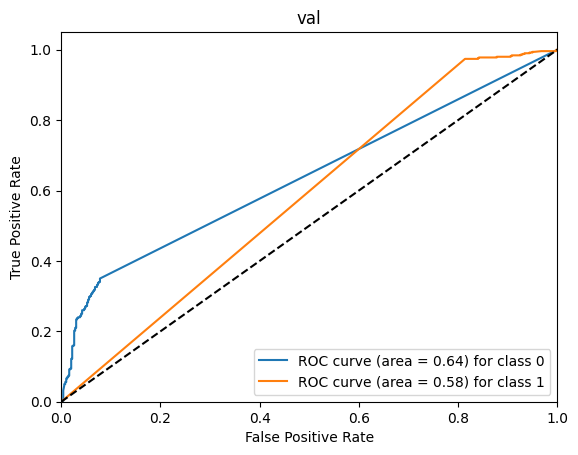

In [35]:
yaml_files = [
    '../input/base_dict.yaml',
    '../input/epoch_dict.yaml',
    '../input/sgd_dict.yaml',
    '../input/sigmoid_dict.yaml',
    '../input/val_dict.yaml'
]

all_histories = []
all_history_names = []
all_metrics = pd.DataFrame()

# Loop through each YAML file
for yaml_file in yaml_files:
    with open(yaml_file, 'r') as file:
          df_dict = yaml.safe_load(file)
          model_histories, history_names, test_table = functions.run_eval(test_generator, **df_dict)

          all_histories.extend(model_histories)
          all_history_names.extend(history_names)
          all_metrics = pd.concat([all_metrics, test_table], ignore_index=True)

# Display model accuracy, precision, recall, & F1 score

In [37]:
all_metrics.drop_duplicates()

,Model,Accuracy,Precision,Recall,F1 Score
0,base,0.506,0.751509,0.506,0.346530
3,epoch,0.531,0.688331,0.531,0.407193
6,sgd,0.619,0.656600,0.619,0.594670
9,sigmoid,0.493,0.339140,0.493,0.333665
12,val,0.528,0.682292,0.528,0.401319
